In [179]:
from statsbombpy import sb

import requests
import json
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
from scipy.linalg import solve

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid", palette = 'deep')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 1. Request data from source. 
Pull data from Statsbombs's open data repository: https://github.com/statsbomb/open-data. 

In [2]:
def load_json(url):
    '''
    Load json data from the given URL.
    '''
    response = requests.get(url)
    return response.json()

In [3]:
def get_season(competition_id, season_id):
    url = f'https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/{competition_id}/{season_id}.json'
    season_js = load_json(url)
    return season_js

Get data for FA Women's Super League 2020/2021 season, using its competition_id (37) and season_id (90).

In [4]:
WSL_2020 = get_season(37, 90)

In [5]:
def get_events(match_id):
    url = f'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json'
    events_js = load_json(url)
    return events_js

Get data for a specific game, Aston Villa vs Arsenal WFC on 2021-02-28 for example, using its match_id (3775648)

In [6]:
events_3775648 = get_events(3775648)

### 2. Manipulate data. 

Relevant information to pull from the event data: 
- __minute and second__: the time when the event happens.
- __x-value__: x coordinate of the event. 
- __y-value__: y coordinate of the event.
- __team__: the team that executes the event. This is critical because in Statsbomb data, the coordinate map rotates when the action team flips, which means (x = 40, y = 30) while ['team'] == team A indicates the same physical location indicated by (x = 80, y = 50) while ['team'] == team B (the opponent).
- __possession__: although soccer is not as "turn-based" as sports like basketball and American football, the flow of play does change when the possession changes. In Statsbomb data, the variable 'possession' indicates a momentary dominance of the play instead of simply touching the ball. That is to say, if when team A has the possession, team B tackles and holds the ball for a few seconds before team A wins it back, the possession team is continuously noted as team A during this sequence.
- __type__: type indicates whether the event is a shot, carry, pass, etc.

In [7]:
def get_df(match_id, team):
    '''
    Generate dataframe containing event info for a selected team during a selected match. 
    
    Arg: match_id(int)
         team(str)
    Return: dataframe
    '''
    events = get_events(match_id)
    events_filter= [{
        'minute': e['minute'], 
        'second': e['second'], 
        'x':e['location'][0],
        'y':e['location'][1],
        'team':e['team']['name'],
        'possession': e['possession_team']['name'], 
        'type': e['type']['name'],
        
        # 'starting' is created to to mark actions like corner, free kick, etc., because they break the sequence.
        'starting': 'Yes' if ('pass' in e and 'type' in e['pass'] and
                            e['pass']['type']['name'] in ['Corner', 'Free Kick', 'Goal Kick', 'Kick Off', 'Throw-in'])
                            else 'No'
    } for e in events if 'location' in e and 'possession_team' in e]
    
    df = pd.DataFrame(events_filter)
    
    df['x'] = df.apply(lambda row: row['x'] if row['team'] == team else 120-row['x'], axis = 1)
    df['y'] = df.apply(lambda row: row['y'] if row['team'] == team else 80-row['y'], axis = 1)

    df['total_seconds'] = df.apply(lambda row: row['minute']*60 + row['second'], axis = 1)

    return df

In [8]:
df = get_df(3775648, 'Arsenal WFC')

In [9]:
df.head()

,minute,second,x,y,team,possession,type,starting,total_seconds
0,0,0,61.0,40.1,Arsenal WFC,Arsenal WFC,Pass,Yes,0
1,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,0
2,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Carry,No,0
3,0,0,59.3,40.8,Arsenal WFC,Arsenal WFC,Pass,No,0
4,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,1


In [10]:
df['dx'] = df['x'].diff()
df['dy'] = df['y'].diff()
df = df.iloc[1:].reset_index(drop=True)

In [11]:
df.isna().sum()

minute           0
second           0
x                0
y                0
team             0
possession       0
type             0
starting         0
total_seconds    0
dx               0
dy               0
dtype: int64

In [12]:
# Calculate the action degree. 
# The results fall in range[-180, 180] with straight forward as 180 and straight backward as -180.
df['degree'] = df.apply(lambda row: np.degrees(np.arctan2(row['dx'],row['dy'])).round(0), axis = 1)

# Calculating the euclidean distance betwen two events helps to review property of data.
df['d'] = df.apply(lambda row: round(math.sqrt(row['dx']**2 + row['dy']**2), 1), axis = 1)

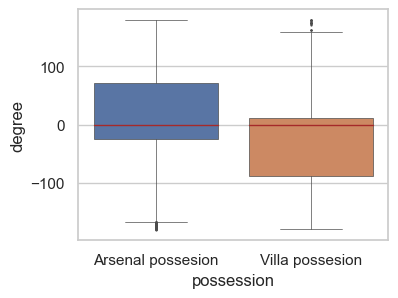

In [132]:
# Use boxplot to review the distribution of action direction
plt.figure(figsize=(4, 3))
ax = sns.boxplot(x='possession', y='degree', data=df, fliersize =0.7, linewidth = 0.5,
           medianprops={'color':'brown', 'linewidth': 1})
ax.set_xticklabels(['Arsenal possesion', 'Villa possesion'])
plt.show()

<Axes: xlabel='degree', ylabel='Count'>

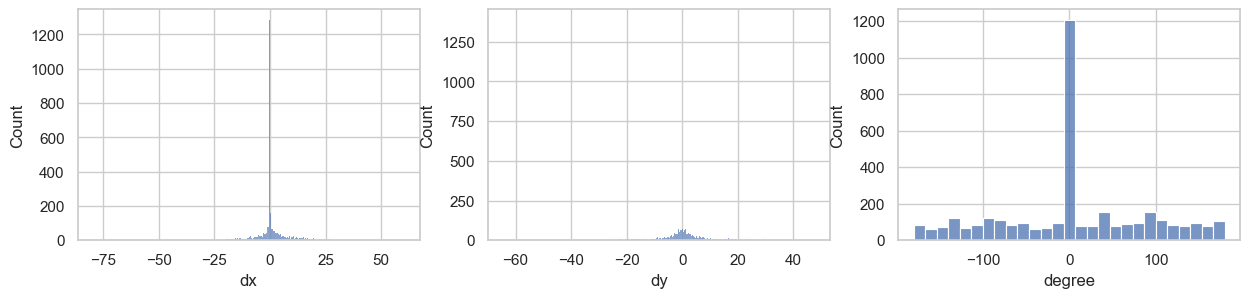

In [133]:
# Anomaly detection following the observation above
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
sns.histplot(df['dx'], ax=axes[0])
sns.histplot(df['dy'], ax=axes[1])
sns.histplot(df['degree'], ax=axes[2])

Observing the unusual high volumn of 0, take a more detailed look at the data.

In [22]:
df.type.value_counts()

type
Pass              1029
Ball Receipt*      999
Carry              936
Pressure           286
Ball Recovery      106
Duel                69
Dribble             49
Interception        48
Block               44
Goal Keeper         39
Clearance           37
Shot                32
Dispossessed        30
Dribbled Past       28
Miscontrol          28
Foul Committed      15
Foul Won            12
Shield               3
50/50                2
Offside              1
Name: count, dtype: int64

The function below checks out the previous and following events for certain type of event.

In [23]:
def check_action(df, action, n):
    '''
    Generate dataframe containing previous and following n rows for certain type of event. 
    
    Arg: df(dataframe)
         action(str)
         n(int)
    Return: dataframe
    '''
    action_idx = df.index[df['type'] == action].tolist()
    display_list = []
    for idx in action_idx:
        display_list.append(idx)
        for offset in range(-n, n+1):
            if (idx + offset) not in display_list:
                display_list.append(idx + offset)
    display_list = [idx for idx in display_list if idx >=0 and idx <len(df)]
    display_list.sort()
    display_df =  df.iloc[display_list]     
    return display_df

In [24]:
display = check_action(df, 'Pressure', 1)
display.head(20)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
10,0,6,53.3,26.8,Arsenal WFC,Arsenal WFC,Carry,No,6,0.0,0.0,0.0,0.0
11,0,7,57.3,25.5,Aston Villa,Arsenal WFC,Pressure,No,7,4.0,-1.3,108.0,4.2
12,0,8,57.2,19.6,Arsenal WFC,Arsenal WFC,Pass,No,8,-0.1,-5.9,-179.0,5.9
14,0,9,62.7,4.6,Arsenal WFC,Arsenal WFC,Carry,No,9,0.0,0.0,0.0,0.0
15,0,9,63.6,8.4,Aston Villa,Arsenal WFC,Pressure,No,9,0.9,3.8,13.0,3.9
16,0,9,63.4,4.6,Arsenal WFC,Arsenal WFC,Pass,No,9,-0.2,-3.8,-177.0,3.8
44,0,36,48.4,3.8,Aston Villa,Aston Villa,Carry,No,36,0.0,0.0,0.0,0.0
45,0,38,49.2,2.7,Arsenal WFC,Aston Villa,Pressure,No,38,0.8,-1.1,144.0,1.4
46,0,38,47.9,3.8,Aston Villa,Aston Villa,Dispossessed,No,38,-1.3,1.1,-50.0,1.7
52,0,40,46.3,16.7,Arsenal WFC,Arsenal WFC,Carry,No,40,0.0,0.0,0.0,0.0


In [25]:
display = check_action(df, 'Block', 1)
display.head(10)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
86,1,27,19.4,25.4,Aston Villa,Aston Villa,Shot,No,87,-1.2,2.5,-26.0,2.8
87,1,27,16.9,27.9,Arsenal WFC,Aston Villa,Block,No,87,-2.5,2.5,-45.0,3.5
88,1,27,1.6,38.6,Arsenal WFC,Aston Villa,Goal Keeper,No,87,-15.3,10.7,-55.0,18.7
190,3,34,74.5,20.3,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,214,12.0,16.2,37.0,20.2
191,3,34,65.0,7.9,Aston Villa,Arsenal WFC,Block,No,214,-9.5,-12.4,-143.0,15.6
192,3,35,63.6,19.5,Aston Villa,Arsenal WFC,Interception,No,215,-1.4,11.6,-7.0,11.7
254,4,53,116.5,37.4,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,293,-1.5,12.3,-7.0,12.4
255,4,53,117.4,28.7,Aston Villa,Arsenal WFC,Block,No,293,0.9,-8.7,174.0,8.7
256,4,54,119.8,37.3,Aston Villa,Arsenal WFC,Goal Keeper,No,294,2.4,8.6,16.0,8.9
332,6,57,95.6,38.9,Arsenal WFC,Arsenal WFC,Shot,No,417,15.3,0.0,90.0,15.3


In [26]:
display = check_action(df, 'Interception', 1)
display.head(10)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
191,3,34,65.0,7.9,Aston Villa,Arsenal WFC,Block,No,214,-9.5,-12.4,-143.0,15.6
192,3,35,63.6,19.5,Aston Villa,Arsenal WFC,Interception,No,215,-1.4,11.6,-7.0,11.7
193,3,35,63.4,19.1,Arsenal WFC,Arsenal WFC,Ball Recovery,No,215,-0.2,-0.4,-153.0,0.4
197,3,37,38.3,19.1,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,217,-16.0,1.9,-83.0,16.1
198,3,37,51.0,18.0,Aston Villa,Arsenal WFC,Interception,No,217,12.7,-1.1,95.0,12.7
199,3,39,51.6,15.7,Arsenal WFC,Arsenal WFC,Pressure,No,219,0.6,-2.3,165.0,2.4
237,4,38,67.8,4.1,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,278,19.3,-45.2,157.0,49.1
238,4,38,68.2,9.1,Aston Villa,Arsenal WFC,Interception,No,278,0.4,5.0,5.0,5.0
239,4,40,48.0,15.2,Arsenal WFC,Arsenal WFC,Pass,No,280,-20.2,6.1,-73.0,21.1
305,6,26,65.1,77.7,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,386,12.8,5.3,68.0,13.9


In [27]:
display = check_action(df, 'Offside', 1)
display.head(10)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
367,7,41,111.6,36.9,Aston Villa,Arsenal WFC,Interception,No,461,0.1,-1.5,176.0,1.5
368,7,44,117.0,13.6,Arsenal WFC,Arsenal WFC,Offside,No,464,5.4,-23.3,167.0,23.9
369,8,15,116.7,21.7,Aston Villa,Aston Villa,Pass,Yes,495,-0.3,8.1,-2.0,8.1


In [28]:
display = check_action(df, 'Ball Receipt*', 1)
display.head(20)

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
0,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,0,1.0,2.2,24.0,2.4
1,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Carry,No,0,0.0,0.0,0.0,0.0
2,0,0,59.3,40.8,Arsenal WFC,Arsenal WFC,Pass,No,0,-2.7,-1.5,-119.0,3.1
3,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,1,-17.3,-0.9,-93.0,17.3
4,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Carry,No,1,0.0,0.0,0.0,0.0
5,0,2,42.9,41.1,Arsenal WFC,Arsenal WFC,Pass,No,2,0.9,1.2,37.0,1.5
6,0,4,40.3,22.7,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,4,-2.6,-18.4,-172.0,18.6
7,0,4,40.3,22.7,Arsenal WFC,Arsenal WFC,Carry,No,4,0.0,0.0,0.0,0.0
8,0,5,40.3,22.7,Arsenal WFC,Arsenal WFC,Pass,No,5,0.0,0.0,0.0,0.0
9,0,6,53.3,26.8,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,6,13.0,4.1,72.0,13.6


In [29]:
# Check the events after "Ball Receipt*"
rec_idx = df.index[df['type'] == 'Ball Receipt*'].tolist()
after_rec_idx = [idx + 1 for idx in rec_idx]
after_rec = df.iloc[after_rec_idx]
after_rec.head()

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
1,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Carry,No,0,0.0,0.0,0.0,0.0
4,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Carry,No,1,0.0,0.0,0.0,0.0
7,0,4,40.3,22.7,Arsenal WFC,Arsenal WFC,Carry,No,4,0.0,0.0,0.0,0.0
10,0,6,53.3,26.8,Arsenal WFC,Arsenal WFC,Carry,No,6,0.0,0.0,0.0,0.0
14,0,9,62.7,4.6,Arsenal WFC,Arsenal WFC,Carry,No,9,0.0,0.0,0.0,0.0


In [30]:
len(after_rec[after_rec['degree'] != 0])

201

In [32]:
after_rec[after_rec['degree'] != 0].head()

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d
39,0,30,80.5,26.0,Aston Villa,Aston Villa,Pass,No,30,1.9,0.4,78.0,1.9
68,0,56,118.8,41.7,Aston Villa,Aston Villa,Goal Keeper,No,56,7.8,6.4,51.0,10.1
93,1,31,46.0,15.1,Aston Villa,Arsenal WFC,Foul Committed,No,91,-10.4,-3.0,-106.0,10.8
191,3,34,65.0,7.9,Aston Villa,Arsenal WFC,Block,No,214,-9.5,-12.4,-143.0,15.6
198,3,37,51.0,18.0,Aston Villa,Arsenal WFC,Interception,No,217,12.7,-1.1,95.0,12.7


Following observations above:
- remove the rows with d < 1 as it's likely just recording a player turned her body after receiving the ball which is less relevant. 
- remove rows of Pressure actions, as the event location was often away from the ball.

In [33]:
df_1 = df[df['d'] >1].reset_index(drop = True)
df_1 =df_1[df_1['type'] != 'Pressure'].reset_index(drop = True)

In addition, remove the rows where column 'starting' has value 'Yes' and the rows right below it. Because 1). the location change between a starting action and the event before is not meaningful; 2). as the starting actions are mostly under zero pressure, it's under different circumstances from the regular play, thus the location change after it is not representative for the analysis focus and will create noise.

In [34]:
df.starting.value_counts()

starting
No     3700
Yes      93
Name: count, dtype: int64

In [35]:
starting_idx = df.index[df['starting'] == 'Yes'].tolist()
df = df.drop(starting_idx + [i + 1 for i in starting_idx])

In [36]:
df_1.describe()

,minute,second,x,y,total_seconds,dx,dy,degree,d
count,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000
mean,45.506932,29.330869,70.121488,39.693623,2759.746765,-0.018438,-0.060767,5.878928,14.104806
std,27.396549,17.074733,28.626072,24.019040,1644.314426,13.490700,13.040860,103.658688,12.368371
min,0.000000,0.000000,0.900000,0.000000,0.000000,-79.500000,-64.300000,-180.000000,1.100000
25%,22.000000,14.000000,48.775000,20.100000,1329.000000,-5.125000,-4.900000,-83.000000,4.700000
50%,45.000000,30.000000,72.100000,38.850000,2715.000000,0.150000,0.050000,6.000000,10.600000
75%,69.000000,44.000000,91.600000,60.650000,4144.250000,6.400000,5.100000,94.250000,19.600000
max,93.000000,59.000000,120.000000,80.000000,5596.000000,60.300000,50.900000,180.000000,81.800000


<Axes: xlabel='degree', ylabel='Count'>

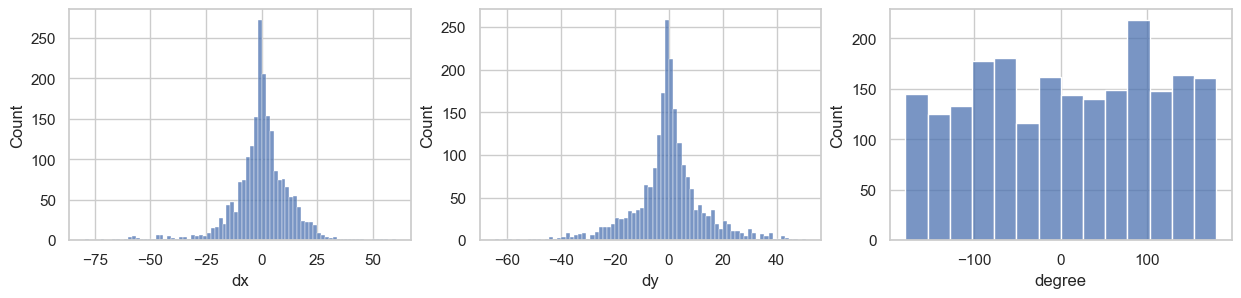

In [127]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
sns.histplot(df_1['dx'], ax=axes[0])
sns.histplot(df_1['dy'], ax=axes[1])
sns.histplot(df_1['degree'], ax=axes[2])

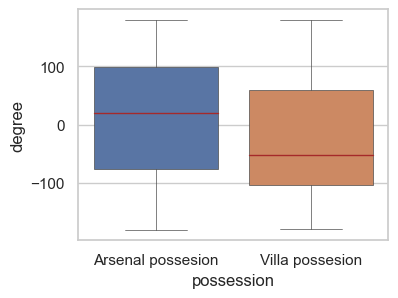

In [128]:
# Use boxplot again after cleaning the data
plt.figure(figsize=(4, 3))
ax = sns.boxplot(x='possession', y='degree', data=df_1, fliersize =0.7, linewidth = 0.5,
           medianprops={'color':'brown', 'linewidth': 1})
ax.set_xticklabels(['Arsenal possesion', 'Villa possesion'])
plt.show()

The plots and the code below check out the covariance between 'degree' and other variables.

<Axes: xlabel='total_seconds', ylabel='degree'>

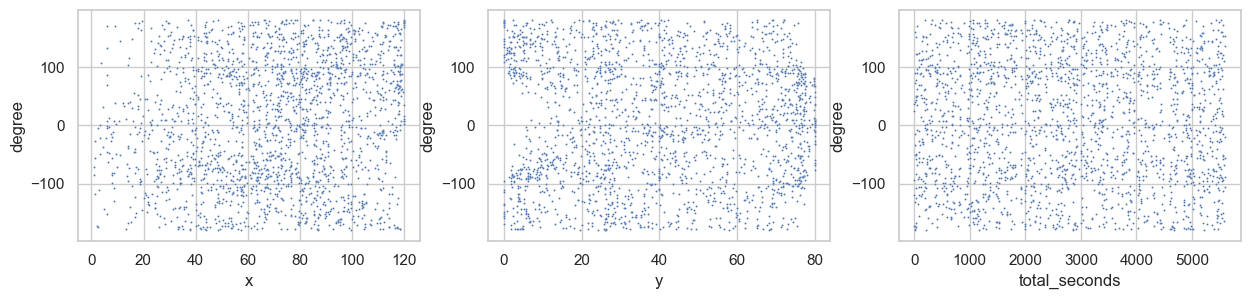

In [129]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
sns.scatterplot(data = df_1, x = 'x', y = 'degree', s = 2, ax=axes[0])
sns.scatterplot(data = df_1, x = 'y', y = 'degree', s = 2, ax=axes[1])
sns.scatterplot(data = df_1, x = 'total_seconds', y = 'degree', s = 2, ax=axes[2])

In [43]:
scaler = StandardScaler()
standardized_df = pd.DataFrame(scaler.fit_transform(df_1[['x', 'y', 'total_seconds', 'degree']]), 
                               columns = df_1[['x', 'y', 'total_seconds', 'degree']].columns)
standardized_df.cov()

,x,y,total_seconds,degree
x,1.000462,-0.015026,-0.055733,0.140942
y,-0.015026,1.000462,0.029599,0.006552
total_seconds,-0.055733,0.029599,1.000462,-0.016848
degree,0.140942,0.006552,-0.016848,1.000462


No strong covariance is observed.

### 3. Calculate Markov matrix. 

Observed the difference in distribution of action direction between possesions, we want to seperate the data based on possesion.

In [87]:
df_2 = df_1.copy()
df_2 = df_2[df_2['possession'] == 'Arsenal WFC'].reset_index(drop = True)

Categorize the action direction by assigning degree > 20° as forward, -20° < degree < 20° as horizontal, degree < -20° as backward. \
Encode the categories into: 0 (forward), 1 (horizontally), 2 (backward)

In [88]:
df_2['direction'] = df_2.apply(
    lambda row: 0 if row['degree'] > 20 else 2 if row['degree'] <-20 else 1, axis = 1)

In [89]:
df_2['direction'].value_counts()

direction
0    868
2    659
1    212
Name: count, dtype: int64

Calculate the probability matrix for all potential transitions between the three states.

In [98]:
len(df_2)

1739

In [172]:
n = 3
directions = df_2.direction

P = np.zeros((n, n))
for i in range(len(directions) - 1):
    P[directions[i], directions[i+1]] += 1
P /= P.sum(axis=1)[:,None]
np.round(P, 2)

array([[0.55, 0.1 , 0.35],
       [0.52, 0.16, 0.32],
       [0.42, 0.14, 0.44]])

Check if those probabilities are constant through the sequence by randomly select subsets from data to analyze.

In [112]:
def calculate_transition_matrix(series, n):
    '''
    Calculate the transition matrix from a series of states.

    Args:
    - series (list or array-like): A sequence of states, each state being an integer between 0 and n-1.
    - n (int): The number of unique states.

    Returns:
    - numpy.ndarray: A `n x n` matrix containing the transition probabilities.
    '''
    P = np.zeros((n, n))
    for i in range(len(series) - 1):
        P[series[i], series[i+1]] += 1
    P /= P.sum(axis=1)[:,None]
    return P

In [156]:
transition_list = ['F_F', 'F_H', 'F_B', 
                  'H_F', 'H_H', 'H_B',
                  'B_F', 'B_H', 'B_B']
transition_probability = {}
for t in transition_list:
    transition_probability[t] = []
    
n_bootstraps = 2000

for _ in range(n_bootstraps):
    # Randomly select 200 rows from the dataset
    t = np.random.randint(0, len(df_2) - 200)
    sample_df = df_2.iloc[t:t+200].reset_index(drop = True)
    
    # Calculate transition matrix
    sample_P = calculate_transition_matrix(sample_df.direction, 3)
    
    # Append probability value to transition_probability dictionary
    for i in range(len(transition_list)):
        key = transition_list[i]
        transition_probability[key].append(sample_P[i//3][i%3])    

In [157]:
transition_df = pd.DataFrame(transition_probability)

In [158]:
transition_df.head()

,F_F,F_H,F_B,H_F,H_H,H_B,B_F,B_H,B_B
0,0.483146,0.134831,0.382022,0.480000,0.160000,0.360000,0.400000,0.105882,0.494118
1,0.489130,0.141304,0.369565,0.500000,0.142857,0.357143,0.430380,0.139241,0.430380
2,0.542857,0.076190,0.380952,0.523810,0.095238,0.380952,0.520548,0.150685,0.328767
3,0.530000,0.110000,0.360000,0.545455,0.136364,0.318182,0.454545,0.103896,0.441558
4,0.484211,0.168421,0.347368,0.551724,0.137931,0.310345,0.453333,0.120000,0.426667


The plots below show the range of transition probabilities calculated from 2000 subset samples.

<Axes: >

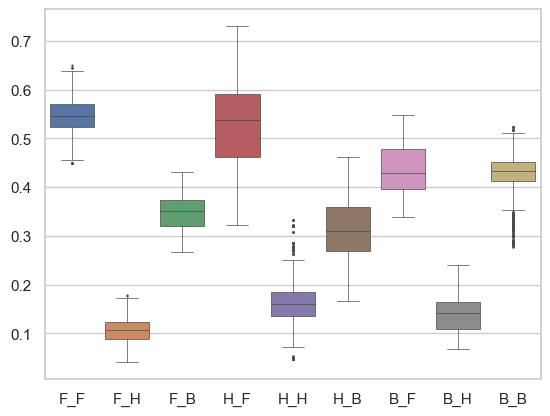

In [159]:
sns.boxplot(data=transition_df, fliersize =0.7, linewidth = 0.5)

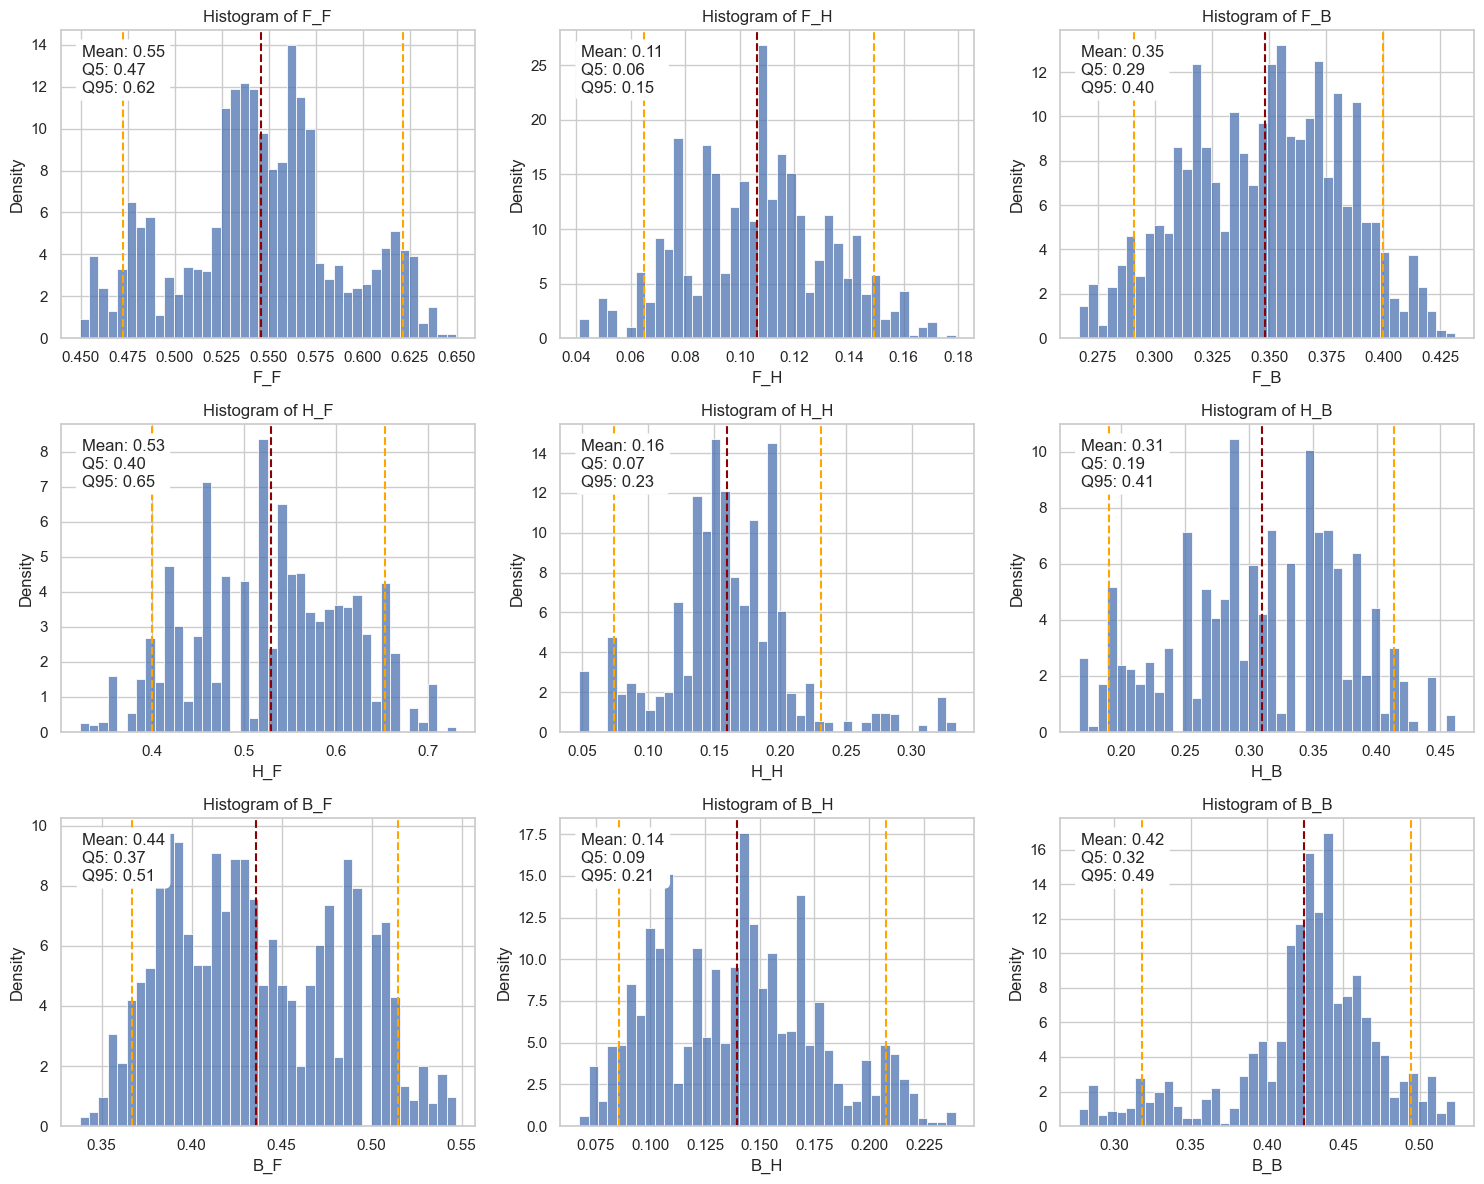

In [169]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

# Plotting histogram for each column
for i in range(3):
    for j in range(3):
        col = transition_df.columns[i * 3 + j]
        sns.histplot(transition_df[col], ax=axs[i, j], stat="density", bins = 40)
        axs[i, j].set_title(f'Histogram of {col}')

        # Adding a line for mean and confidence interval (95%)
        mean = transition_df[col].mean()
        Q5, Q95 = np.percentile(transition_df[col], [5, 95])
        axs[i, j].axvline(mean, color='darkred', linestyle='--')
        axs[i, j].axvline(Q5, color='orange', linestyle='--')
        axs[i, j].axvline(Q95, color='orange', linestyle='--')
        
        annotation = f'Mean: {mean:.2f}\nQ5: {Q5:.2f}\nQ95: {Q95:.2f}'
        axs[i, j].annotate(annotation, xy=(0.05, 0.8), xycoords='axes fraction', 
                           bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))
        
plt.tight_layout()
plt.show()

### 4. Calculate and plot state vectors. 

In [170]:
df_2.head()

,minute,second,x,y,team,possession,type,starting,total_seconds,dx,dy,degree,d,direction
0,0,0,62.0,42.3,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,0,1.0,2.2,24.0,2.4,0
1,0,0,59.3,40.8,Arsenal WFC,Arsenal WFC,Pass,No,0,-2.7,-1.5,-119.0,3.1,2
2,0,1,42.0,39.9,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,1,-17.3,-0.9,-93.0,17.3,2
3,0,2,42.9,41.1,Arsenal WFC,Arsenal WFC,Pass,No,2,0.9,1.2,37.0,1.5,0
4,0,4,40.3,22.7,Arsenal WFC,Arsenal WFC,Ball Receipt*,No,4,-2.6,-18.4,-172.0,18.6,2


In [171]:
start_vector = np.array([0,1,0])

In [175]:
state_vectors = [start_vector]
for _ in range(10):
    next_vector = np.dot(state_vectors[-1], P)
    state_vectors.append(next_vector)

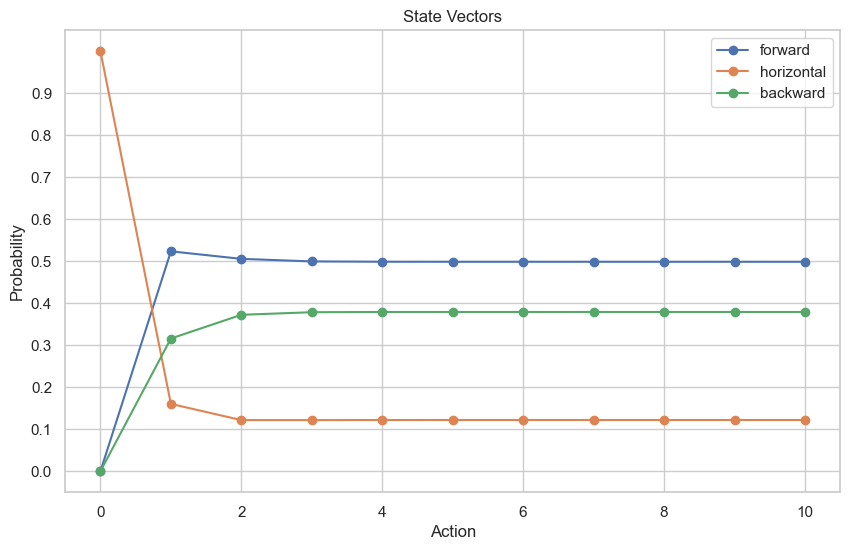

In [182]:
state_vectors = np.array(state_vectors)
plt.figure(figsize=(10, 6))
plt.plot(state_vectors, marker='o')
plt.yticks(np.arange(0,1,0.1))
plt.title('State Vectors')
plt.xlabel('Action')
plt.ylabel('Probability')
plt.legend(['forward', 'horizontal', 'backward'])
plt.show()

In [183]:
A = np.vstack([P.T - np.eye(n), np.ones(n)])
b = np.zeros(n + 1)
b[-1] = 1  
stationary_prob_vector = solve(A.T @ A, A.T @ b)
np.round(stationary_prob_vector, 2)

array([0.5 , 0.12, 0.38])

In [184]:
P0 = np.round(P,2)

In [185]:
P0

array([[0.55, 0.1 , 0.35],
       [0.52, 0.16, 0.32],
       [0.42, 0.14, 0.44]])

In [187]:
second_vector = np.dot(start_vector, P0)
second_vector

array([0.52, 0.16, 0.32])

In [191]:
third = np.dot(second_vector, P0)
np.round(third,2)

array([0.5 , 0.12, 0.37])